# ODE models for all the cells

In [10]:
import numpy as np
import math
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

In [2]:
import os
cwd = os.getcwd()

Importing the data

In [3]:
Genotypes = ['WT(JR667)', 'elt-1(ku491)', 'egl-18(ga97)', 'ceh-16(bp323)'] #change this for all genotypes
Genes = ['elt-1', 'egl-18', 'ceh-16']
Seam_cells = ['H0', 'H1', 'H2', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'T']
Proteins = ['ELT-1', 'EGL-18', 'CEH-16']
mRNA = ['$elt$-1', '$egl$-18', '$ceh$-16']
mRNA = ['elt-1', 'egl-18', 'ceh-16']

In [4]:
pd_DATA = {'elt-1':{}, 'egl-18':{}, 'ceh-16':{}}

In [5]:
#This needs to be adapted to read your files depending on where they are located

#WT
pd_DATA['elt-1']['WT(JR667)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_elt-1_wt.csv")
pd_DATA['egl-18']['WT(JR667)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_egl-18_wt.csv")
pd_DATA['ceh-16']['WT(JR667)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_ceh-16_wt.csv").rename(columns={"ROI attribute": "Cell", "#Experiment": "Worm", "n_mRNA": "mRNA"}) 

#elt-1 mutant
pd_DATA['elt-1']['elt-1(ku491)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_elt-1_elt-1_M.csv").rename(columns={"Seam_cell": "Cell"})
pd_DATA['egl-18']['elt-1(ku491)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_egl-18_elt-1_M.csv").drop(['Probe'], axis=1).drop(['Strain'], axis=1).rename(columns={"Scm_cell": "Cell"})
pd_DATA['ceh-16']['elt-1(ku491)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_ceh-16_elt-1_M.csv").rename(columns={"Seam_cell": "Cell"}).replace("V1 ", "V1")

#egl-18 mutant
pd_DATA['elt-1']['egl-18(ga97)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_elt-1_egl-18_M.csv").drop(['Probe'], axis=1).drop(['Strain'], axis=1).rename(columns={"Seam_cell": "Cell"})
pd_DATA['egl-18']['egl-18(ga97)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_egl-18_egl-18_M.csv").rename(columns={"ROI attribute": "Cell", "Worm #": "Worm", "mRNA Count": "mRNA"})
pd_DATA['ceh-16']['egl-18(ga97)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_ceh-16_egl-18_M.csv").drop(['Probe'], axis=1).drop(['Mutant'], axis=1).rename(columns={"Seam_cell": "Cell"})

#ceh-16 mutant
pd_DATA['elt-1']['ceh-16(bp323)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_elt-1_ceh-16_M.csv").drop(['strain'], axis=1).rename(columns={"Seam_cell": "Cell"})
pd_DATA['egl-18']['ceh-16(bp323)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_egl-18_ceh-16_M.csv").drop(['Probe'], axis=1).drop(['Mutant'], axis=1).rename(columns={"Seam_cell": "Cell"})
pd_DATA['ceh-16']['ceh-16(bp323)'] = pd.read_csv(cwd+"/DATA_FULL_ALL_TIMEPOINTS/17_ceh-16_ceh-16_M.csv").rename(columns={"ROI attribute": "Cell", "Worm #": "Worm", "mRNA Count": "mRNA"})


In [6]:
group1 = ['H0', 'H1', 'H2']
group2 = ['V1', 'V2', 'V3', 'V4']
group3 = ['V5', 'V6', 'T']

# MRA

Note that the only useful matrix is the r matrix called "Network interaction map or connectivity matrix"

That gives us the coefficients $r_{ij}$ that represent the action of the element in column $j$ on the element in row $i$.

If:

$r_{ij}>0$ activation (if $r_{ij}>1$ small changes in $j$ are amplified in $i$, if $0<r_{ij}<1$ they are attenuated)

$r_{ij}=0$ no relationship

$r_{ij}<0$ repression (if $r_{ij}<-1$ small changes in $j$ are amplified in $i$, if $-1<r_{ij}<0$ they are attenuated)

Note that $r_{ii}:=-1$ $\forall i=1,2,3$.

In [11]:
#MRA discarding the non-invertible Rp s
#function for finding the network interaction map r for our 3x3 genetic network
#FOR GROUPS!
def MRA_average_discarding_non_inv_group_CI_fixed_perturbations(data, group, perturbations=[0.25, 0., 0.25], key_j=Genes, keys_i=Genotypes, num_it=10000, non_inv=1e-16, boxplot=True):
    """data is a dictionary with keys the names in the group e.g. H0, H1, H2
    each key opens another dictionary with keys 'WT', 'M_elt-1', 'M_egl-18', 'M_ceh-16'
    each key opens another dictionary with as keys 'elt-1', 'egl-18', 'ceh-16'
    the data is related to just one cell or one group of cells that have similar behaviour
    each key of key opens a np.array of shape (number, 1)"""
    Rp = np.zeros((3,3))
    r = np.zeros((3,3))
    Rp_all = [np.zeros((3,3)) for n in range(num_it)]
    r_all = [np.zeros((3,3)) for n in range(num_it)]
    count = 0
    
    #Perturbing the data e.g. [0.25, 0., 0.25]
    for k in group:
        for i in range(len(Genes)):
            data[k][Genes[i]][Genotypes[i+1]] *= perturbations[i]
            
    for j in Genes:
        delta_i_ln_x_j = np.zeros(3)
        for n in range(num_it):
            x = []
            for i in Genotypes:
                np.random.seed(77*n+13*count)
                tot = []
                for k in group:
                    num_data = data[k][j][i].shape[0] #NOTE: inverted indices, not as usual
                    ind = np.random.randint(0, num_data, size=(num_data,))
                    data_sample = np.array([data[k][j][i][k1] for k1 in ind]) #NOTE: inverted indices, not as usual
                    tot.append(np.mean(data_sample))
                x.append(np.mean(np.array(tot)))
            for i in range(3):
                delta_i_ln_x_j_comp = (2*(x[i+1]-x[0])/(x[i+1]+x[0]))
                delta_i_ln_x_j[i] += delta_i_ln_x_j_comp
                Rp_all[n][count,i] = 1.0*delta_i_ln_x_j_comp
        Rp[count, :] = delta_i_ln_x_j / num_it
        #print(Rp[count][:])
        count += 1 
        
    inv_count = 0
    for n in range(num_it):
        #print(n)
        Rp_inv = np.linalg.inv(Rp_all[n])
        #print(np.diag(Rp_inv))
        if np.all(np.abs(np.diag(Rp_inv)) >= non_inv): #10^-16
            #print(n)
            r_all[n] = -np.diag(1/np.diag(Rp_inv)).dot(Rp_inv)
            inv_count += 1
            
    r = sum(r_all) / inv_count
    
    five_perc = inv_count * 5 // 100
    r_all_sort = np.sort(np.array(r_all), axis=0)
    r_min = r_all_sort[0,:,:]
    r_max = r_all_sort[-1,:,:]
    r_low = r_all_sort[five_perc,:,:]
    r_up = r_all_sort[-five_perc-1,:,:]
    
    if boxplot:
        colmap = cm.get_cmap('RdYlGn')
        plt.figure(figsize=(10,5))
        #plt.title('Coefficients of Network Interaction Maps')
        bp = plt.boxplot([r_all_sort[:,i,j] for i in range(3) for j in range(3)],
                         patch_artist=True, meanprops=dict(color='black'),
                         medianprops=dict(color='black'))
        for i in range(3):
            for j in range(3):
                bp['boxes'][j+3*i].set_facecolor(colmap((r[i,j]+1)/2))
                
        plt.xticks(np.arange(1,10),[j+'\n action on \n'+i for i in mRNA for j in Proteins])
        plt.axhline(y=0, linestyle='--', color='grey', zorder=0)
        plt.show()
    
    return Rp, r, inv_count, r_min, r_max, r_low, r_up

We now proceed to apply the function to different cell groups.

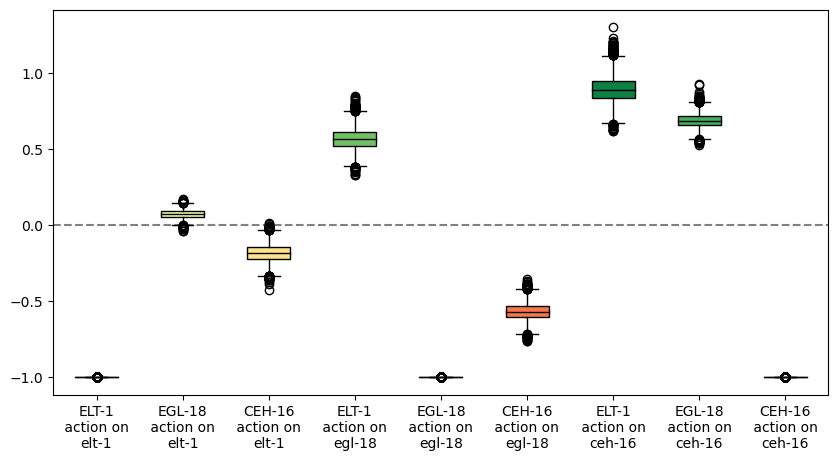



Response matrix or gene expression matrix for ['H0', 'H1', 'H2', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.10,0.09,0.37
egl-18,-0.05,-2.00,1.10
ceh-16,-1.01,-1.29,-1.57



Network interaction map or connectivity matrix for ['H0', 'H1', 'H2', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.07,-0.18
egl-18,0.57,-1.00,-0.57
ceh-16,0.89,0.69,-1.00



Min network interaction map or connectivity matrix for ['H0', 'H1', 'H2', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.04,-0.42
egl-18,0.33,-1.00,-0.76
ceh-16,0.62,0.53,-1.00



Max network interaction map or connectivity matrix for ['H0', 'H1', 'H2', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.17,0.01
egl-18,0.85,-1.00,-0.36
ceh-16,1.30,0.92,-1.00



Lower network interaction map or connectivity matrix for ['H0', 'H1', 'H2', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.03,-0.27
egl-18,0.46,-1.00,-0.65
ceh-16,0.76,0.61,-1.00



Upper network interaction map or connectivity matrix for ['H0', 'H1', 'H2', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.12,-0.09
egl-18,0.68,-1.00,-0.48
ceh-16,1.04,0.76,-1.00



Invertible Rp = 10000 



In [12]:
#FIND INTERACTION MAPS WITH 30 SAMPLES FOR ALL CELLS
group4 = Seam_cells
data = {}
for k in group4:
    #prepare the data
    data[k] = {'elt-1':{}, 'egl-18':{}, 'ceh-16':{}}
    for i in Genes:
        for j in Genotypes:
            data[k][i][j] = np.array(pd_DATA[i][j][pd_DATA[i][j].Cell == k].mRNA, dtype='float64')
    #print(data)
Rp_cells_p, r_cells_p, inv_count_p, r_min_p, r_max_p, r_low_p, r_up_p = MRA_average_discarding_non_inv_group_CI_fixed_perturbations(data, group4)

visualize1 = pd.DataFrame(Rp_cells_p, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\n\nResponse matrix or gene expression matrix for", group4)
display(visualize1.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

visualize2 = pd.DataFrame(r_cells_p, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nNetwork interaction map or connectivity matrix for", group4)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_min_p, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nMin network interaction map or connectivity matrix for", group4)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_max_p, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nMax network interaction map or connectivity matrix for", group4)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_low_p, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nLower network interaction map or connectivity matrix for", group4)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_up_p, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nUpper network interaction map or connectivity matrix for", group4)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

print("\nInvertible Rp =", inv_count_p, "\n")

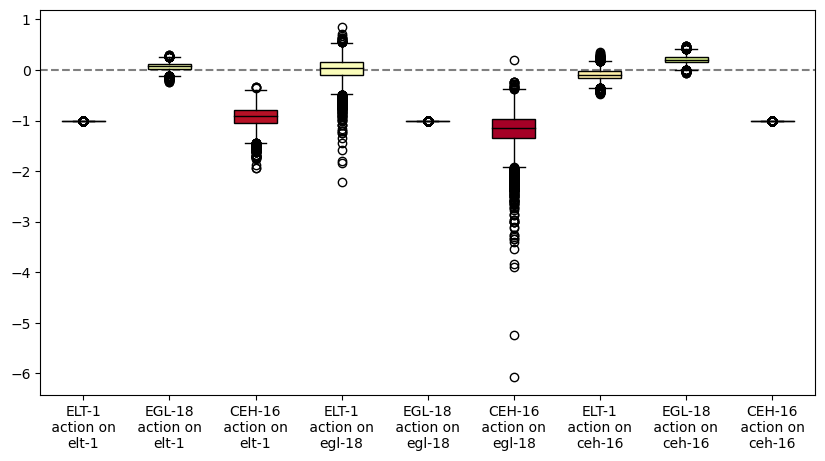



Response matrix or gene expression matrix for ['H0', 'H1', 'H2']


,ELT-1,EGL-18,CEH-16
elt-1,-0.94,0.26,0.84
egl-18,-0.11,-2.00,0.99
ceh-16,0.06,-0.44,-0.84



Network interaction map or connectivity matrix for ['H0', 'H1', 'H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.07,-0.93
egl-18,0.02,-1.00,-1.18
ceh-16,-0.09,0.21,-1.00



Min network interaction map or connectivity matrix for ['H0', 'H1', 'H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.25,-1.93
egl-18,-2.21,-1.00,-6.08
ceh-16,-0.48,-0.07,-1.00



Max network interaction map or connectivity matrix for ['H0', 'H1', 'H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.30,-0.33
egl-18,0.84,-1.00,0.20
ceh-16,0.35,0.48,-1.00



Lower network interaction map or connectivity matrix for ['H0', 'H1', 'H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.05,-1.27
egl-18,-0.35,-1.00,-1.78
ceh-16,-0.26,0.08,-1.00



Upper network interaction map or connectivity matrix for ['H0', 'H1', 'H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.18,-0.62
egl-18,0.32,-1.00,-0.72
ceh-16,0.08,0.33,-1.00



Invertible Rp = 10000 



In [13]:
#FIND INTERACTION MAPS WITH 30 SAMPLES FOR group1
data = {}
for k in group1:
    #prepare the data
    data[k] = {'elt-1':{}, 'egl-18':{}, 'ceh-16':{}}
    for i in Genes:
        for j in Genotypes:
            data[k][i][j] = np.array(pd_DATA[i][j][pd_DATA[i][j].Cell == k].mRNA, dtype='float64')
    #print(data)
Rp_cells_p1, r_cells_p1, inv_count_p1, r_min_p1, r_max_p1, r_low_p1, r_up_p1 = MRA_average_discarding_non_inv_group_CI_fixed_perturbations(data, group1)

visualize1 = pd.DataFrame(Rp_cells_p1, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\n\nResponse matrix or gene expression matrix for", group1)
display(visualize1.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

visualize2 = pd.DataFrame(r_cells_p1, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nNetwork interaction map or connectivity matrix for", group1)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_min_p1, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nMin network interaction map or connectivity matrix for", group1)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_max_p1, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nMax network interaction map or connectivity matrix for", group1)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_low_p1, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nLower network interaction map or connectivity matrix for", group1)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_up_p1, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nUpper network interaction map or connectivity matrix for", group1)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

print("\nInvertible Rp =", inv_count_p1, "\n")

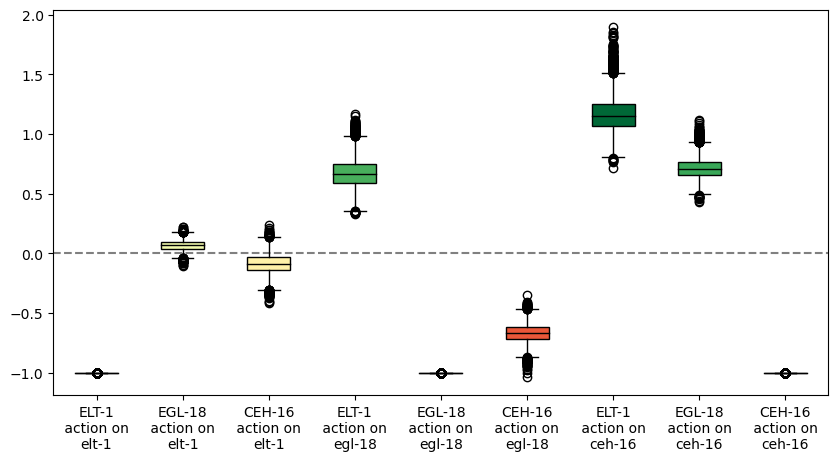



Response matrix or gene expression matrix for ['V1', 'V2', 'V3', 'V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.15,-0.00,0.23
egl-18,0.08,-2.00,1.26
ceh-16,-1.27,-1.42,-1.66



Network interaction map or connectivity matrix for ['V1', 'V2', 'V3', 'V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.07,-0.09
egl-18,0.67,-1.00,-0.67
ceh-16,1.16,0.71,-1.00



Min network interaction map or connectivity matrix for ['V1', 'V2', 'V3', 'V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.10,-0.41
egl-18,0.33,-1.00,-1.04
ceh-16,0.72,0.43,-1.00



Max network interaction map or connectivity matrix for ['V1', 'V2', 'V3', 'V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.22,0.23
egl-18,1.17,-1.00,-0.35
ceh-16,1.89,1.12,-1.00



Lower network interaction map or connectivity matrix for ['V1', 'V2', 'V3', 'V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.00,-0.23
egl-18,0.49,-1.00,-0.79
ceh-16,0.96,0.59,-1.00



Upper network interaction map or connectivity matrix for ['V1', 'V2', 'V3', 'V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.13,0.04
egl-18,0.88,-1.00,-0.55
ceh-16,1.40,0.86,-1.00



Invertible Rp = 10000 



In [14]:
#FIND INTERACTION MAPS WITH 30 SAMPLES FOR group2
data = {}
for k in group2:
    #prepare the data
    data[k] = {'elt-1':{}, 'egl-18':{}, 'ceh-16':{}}
    for i in Genes:
        for j in Genotypes:
            data[k][i][j] = np.array(pd_DATA[i][j][pd_DATA[i][j].Cell == k].mRNA, dtype='float64')
    #print(data)
Rp_cells_p2, r_cells_p2, inv_count_p2, r_min_p2, r_max_p2, r_low_p2, r_up_p2 = MRA_average_discarding_non_inv_group_CI_fixed_perturbations(data, group2)

visualize1 = pd.DataFrame(Rp_cells_p2, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\n\nResponse matrix or gene expression matrix for", group2)
display(visualize1.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

visualize2 = pd.DataFrame(r_cells_p2, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nNetwork interaction map or connectivity matrix for", group2)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_min_p2, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nMin network interaction map or connectivity matrix for", group2)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_max_p2, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nMax network interaction map or connectivity matrix for", group2)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_low_p2, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nLower network interaction map or connectivity matrix for", group2)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_up_p2, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nUpper network interaction map or connectivity matrix for", group2)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

print("\nInvertible Rp =", inv_count_p2, "\n")

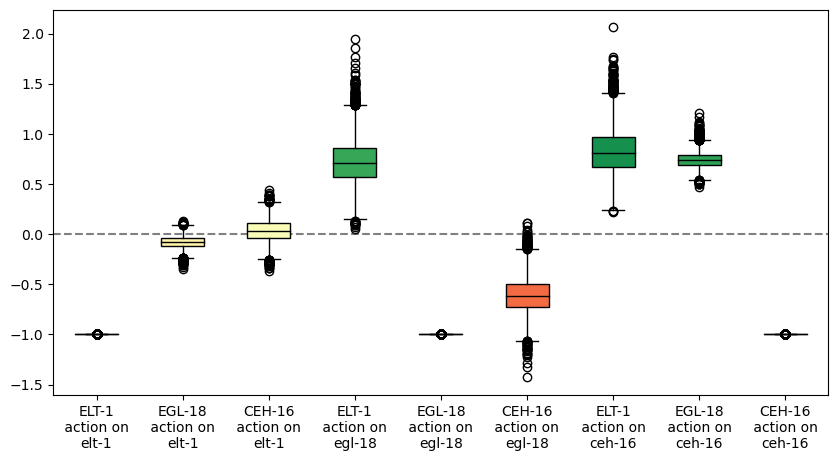



Response matrix or gene expression matrix for ['V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.13,0.10,-0.12
egl-18,-0.17,-2.00,0.91
ceh-16,-1.05,-1.40,-1.67



Network interaction map or connectivity matrix for ['V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.07,0.03
egl-18,0.72,-1.00,-0.60
ceh-16,0.83,0.74,-1.00



Min network interaction map or connectivity matrix for ['V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.35,-0.37
egl-18,0.05,-1.00,-1.43
ceh-16,0.22,0.48,-1.00



Max network interaction map or connectivity matrix for ['V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.13,0.44
egl-18,1.95,-1.00,0.11
ceh-16,2.06,1.21,-1.00



Lower network interaction map or connectivity matrix for ['V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.17,-0.14
egl-18,0.38,-1.00,-0.86
ceh-16,0.49,0.63,-1.00



Upper network interaction map or connectivity matrix for ['V5', 'V6', 'T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.02,0.21
egl-18,1.08,-1.00,-0.31
ceh-16,1.20,0.88,-1.00



Invertible Rp = 10000 



In [15]:
#FIND INTERACTION MAPS WITH 30 SAMPLES FOR group3
data = {}
for k in group3:
    #prepare the data
    data[k] = {'elt-1':{}, 'egl-18':{}, 'ceh-16':{}}
    for i in Genes:
        for j in Genotypes:
            data[k][i][j] = np.array(pd_DATA[i][j][pd_DATA[i][j].Cell == k].mRNA, dtype='float64')
    #print(data)
Rp_cells_p3, r_cells_p3, inv_count_p3, r_min_p3, r_max_p3, r_low_p3, r_up_p3 = MRA_average_discarding_non_inv_group_CI_fixed_perturbations(data, group3)

visualize1 = pd.DataFrame(Rp_cells_p3, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\n\nResponse matrix or gene expression matrix for", group3)
display(visualize1.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

visualize2 = pd.DataFrame(r_cells_p3, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nNetwork interaction map or connectivity matrix for", group3)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_min_p3, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nMin network interaction map or connectivity matrix for", group3)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_max_p3, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nMax network interaction map or connectivity matrix for", group3)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_low_p3, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nLower network interaction map or connectivity matrix for", group3)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
visualize2 = pd.DataFrame(r_up_p3, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
print("\nUpper network interaction map or connectivity matrix for", group3)
display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

print("\nInvertible Rp =", inv_count_p3, "\n")

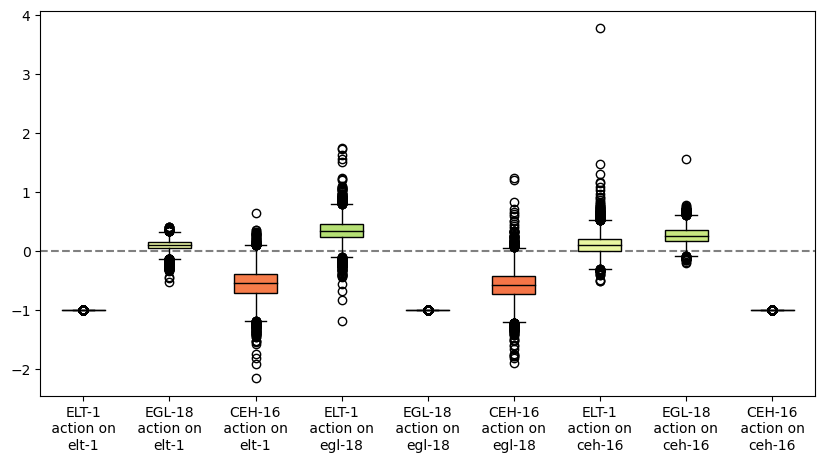



Response matrix or gene expression matrix for ['H0']


,ELT-1,EGL-18,CEH-16
elt-1,-1.04,0.08,0.66
egl-18,-0.25,-2.00,0.84
ceh-16,-0.18,-0.52,-1.07



Network interaction map or connectivity matrix for ['H0']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.10,-0.55
egl-18,0.34,-1.00,-0.57
ceh-16,0.11,0.26,-1.00



Min network interaction map or connectivity matrix for ['H0']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.53,-2.16
egl-18,-1.19,-1.00,-1.90
ceh-16,-0.51,-0.20,-1.00



Max network interaction map or connectivity matrix for ['H0']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.41,0.65
egl-18,1.75,-1.00,1.23
ceh-16,3.77,1.56,-1.00



Lower network interaction map or connectivity matrix for ['H0']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.06,-0.96
egl-18,0.04,-1.00,-0.97
ceh-16,-0.13,0.05,-1.00



Upper network interaction map or connectivity matrix for ['H0']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.24,-0.17
egl-18,0.64,-1.00,-0.18
ceh-16,0.38,0.48,-1.00



Invertible Rp = 10000 



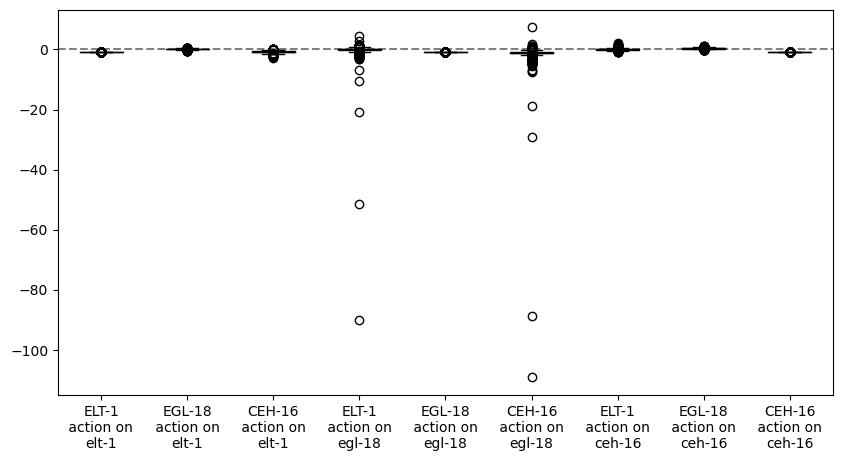



Response matrix or gene expression matrix for ['H1']


,ELT-1,EGL-18,CEH-16
elt-1,-0.96,0.36,0.84
egl-18,0.02,-2.00,1.09
ceh-16,-0.03,-0.64,-1.04



Network interaction map or connectivity matrix for ['H1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.05,-0.77
egl-18,-0.04,-1.00,-1.11
ceh-16,0.04,0.33,-1.00



Min network interaction map or connectivity matrix for ['H1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.66,-2.69
egl-18,-90.04,-1.00,-109.15
ceh-16,-0.94,-0.33,-1.00



Max network interaction map or connectivity matrix for ['H1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.40,0.14
egl-18,4.48,-1.00,7.35
ceh-16,2.00,1.16,-1.00



Lower network interaction map or connectivity matrix for ['H1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.12,-1.24
egl-18,-0.55,-1.00,-1.81
ceh-16,-0.24,0.13,-1.00



Upper network interaction map or connectivity matrix for ['H1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.22,-0.35
egl-18,0.39,-1.00,-0.56
ceh-16,0.36,0.53,-1.00



Invertible Rp = 10000 



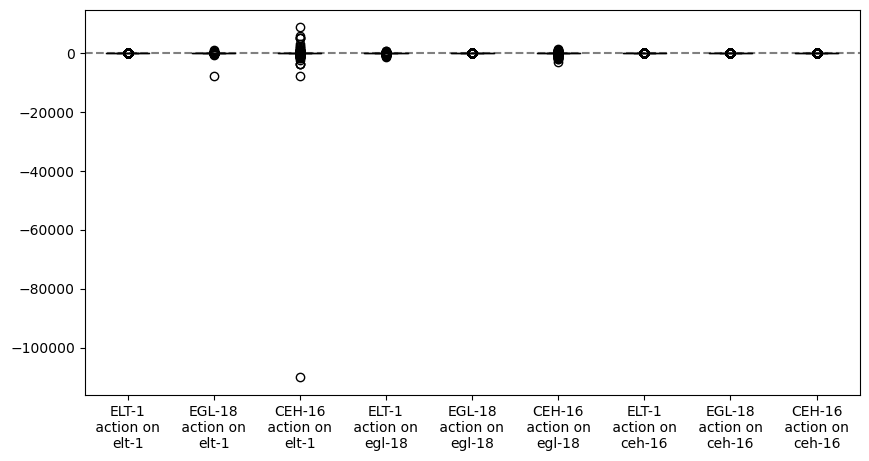



Response matrix or gene expression matrix for ['H2']


,ELT-1,EGL-18,CEH-16
elt-1,-0.80,0.32,0.93
egl-18,-0.10,-2.00,1.01
ceh-16,0.49,-0.07,-0.25



Network interaction map or connectivity matrix for ['H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.44,-12.85
egl-18,0.28,-1.00,-0.62
ceh-16,-0.69,-0.10,-1.00



Min network interaction map or connectivity matrix for ['H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-7641.94,-110040.96
egl-18,-1267.93,-1.00,-3041.91
ceh-16,-62.99,-25.87,-1.00



Max network interaction map or connectivity matrix for ['H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,908.84,8684.17
egl-18,533.44,-1.00,1298.04
ceh-16,130.24,36.90,-1.00



Lower network interaction map or connectivity matrix for ['H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-1.56,-21.12
egl-18,-4.93,-1.00,-12.67
ceh-16,-1.34,-0.44,-1.00



Upper network interaction map or connectivity matrix for ['H2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,1.71,17.74
egl-18,7.01,-1.00,14.78
ceh-16,-0.21,0.21,-1.00



Invertible Rp = 10000 



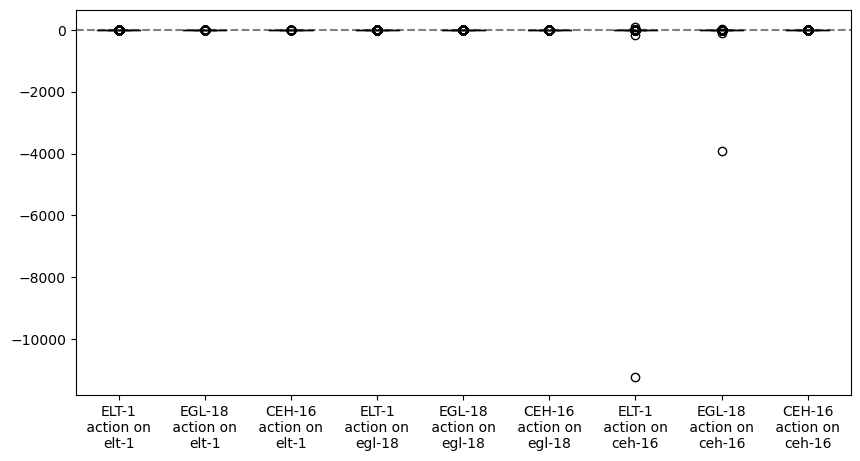



Response matrix or gene expression matrix for ['V1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.13,-0.00,0.37
egl-18,-0.11,-2.00,1.21
ceh-16,-1.29,-1.34,-1.62



Network interaction map or connectivity matrix for ['V1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.10,-0.15
egl-18,0.77,-1.00,-0.58
ceh-16,-0.00,0.30,-1.00



Min network interaction map or connectivity matrix for ['V1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.25,-0.79
egl-18,0.10,-1.00,-2.29
ceh-16,-11243.28,-3905.69,-1.00



Max network interaction map or connectivity matrix for ['V1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.40,0.57
egl-18,2.64,-1.00,0.36
ceh-16,82.66,29.96,-1.00



Lower network interaction map or connectivity matrix for ['V1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.03,-0.45
egl-18,0.44,-1.00,-0.88
ceh-16,0.71,0.44,-1.00



Upper network interaction map or connectivity matrix for ['V1']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.23,0.14
egl-18,1.17,-1.00,-0.28
ceh-16,1.77,1.02,-1.00



Invertible Rp = 10000 



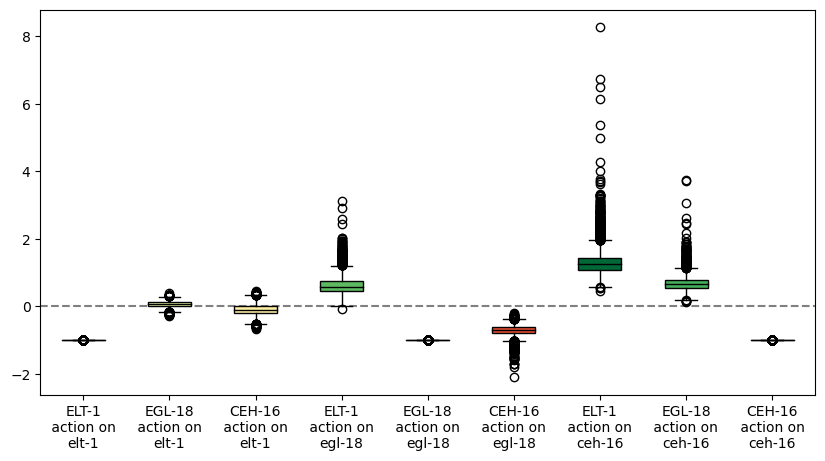



Response matrix or gene expression matrix for ['V2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.13,-0.02,0.24
egl-18,0.21,-2.00,1.27
ceh-16,-1.28,-1.34,-1.63



Network interaction map or connectivity matrix for ['V2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.07,-0.09
egl-18,0.62,-1.00,-0.70
ceh-16,1.31,0.68,-1.00



Min network interaction map or connectivity matrix for ['V2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.28,-0.67
egl-18,-0.07,-1.00,-2.10
ceh-16,0.47,0.13,-1.00



Max network interaction map or connectivity matrix for ['V2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.39,0.45
egl-18,3.11,-1.00,-0.19
ceh-16,8.27,3.76,-1.00



Lower network interaction map or connectivity matrix for ['V2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.07,-0.36
egl-18,0.28,-1.00,-0.92
ceh-16,0.91,0.40,-1.00



Upper network interaction map or connectivity matrix for ['V2']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.21,0.16
egl-18,1.04,-1.00,-0.50
ceh-16,1.87,1.02,-1.00



Invertible Rp = 10000 



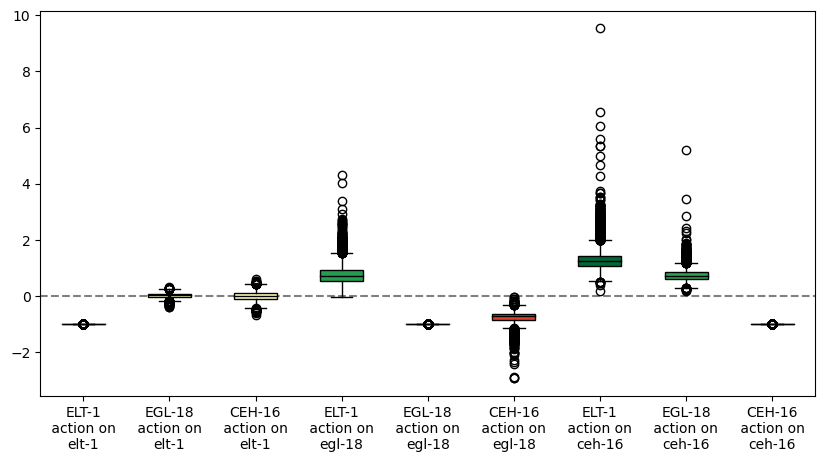



Response matrix or gene expression matrix for ['V3']


,ELT-1,EGL-18,CEH-16
elt-1,-1.10,-0.04,0.05
egl-18,0.12,-2.00,1.25
ceh-16,-1.29,-1.50,-1.69



Network interaction map or connectivity matrix for ['V3']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.03,-0.01
egl-18,0.77,-1.00,-0.74
ceh-16,1.29,0.75,-1.00



Min network interaction map or connectivity matrix for ['V3']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.40,-0.68
egl-18,-0.05,-1.00,-2.93
ceh-16,0.19,0.17,-1.00



Max network interaction map or connectivity matrix for ['V3']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.31,0.60
egl-18,4.30,-1.00,-0.03
ceh-16,9.53,5.21,-1.00



Lower network interaction map or connectivity matrix for ['V3']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.12,-0.28
egl-18,0.32,-1.00,-1.06
ceh-16,0.84,0.47,-1.00



Upper network interaction map or connectivity matrix for ['V3']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.15,0.25
egl-18,1.35,-1.00,-0.47
ceh-16,1.91,1.07,-1.00



Invertible Rp = 10000 



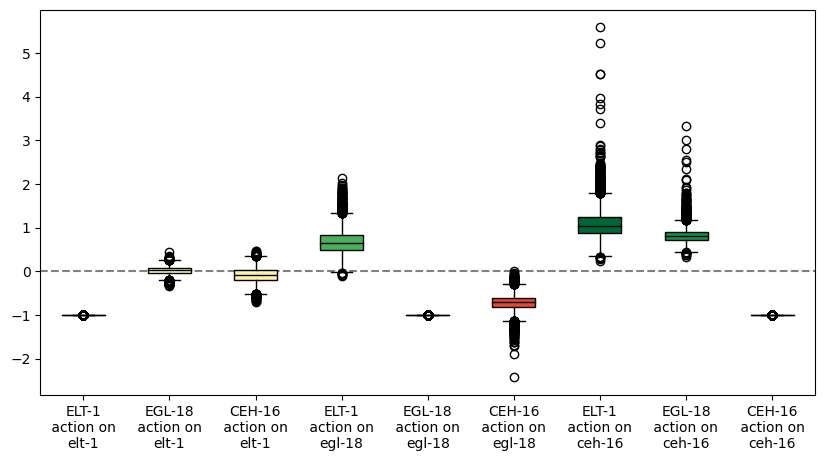



Response matrix or gene expression matrix for ['V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.21,0.09,0.17
egl-18,0.07,-2.00,1.30
ceh-16,-1.23,-1.52,-1.71



Network interaction map or connectivity matrix for ['V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.02,-0.08
egl-18,0.67,-1.00,-0.71
ceh-16,1.08,0.82,-1.00



Min network interaction map or connectivity matrix for ['V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.35,-0.71
egl-18,-0.12,-1.00,-2.43
ceh-16,0.25,0.32,-1.00



Max network interaction map or connectivity matrix for ['V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.45,0.47
egl-18,2.13,-1.00,0.01
ceh-16,5.59,3.33,-1.00



Lower network interaction map or connectivity matrix for ['V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.13,-0.35
egl-18,0.29,-1.00,-0.98
ceh-16,0.66,0.60,-1.00



Upper network interaction map or connectivity matrix for ['V4']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.16,0.17
egl-18,1.13,-1.00,-0.43
ceh-16,1.61,1.10,-1.00



Invertible Rp = 10000 



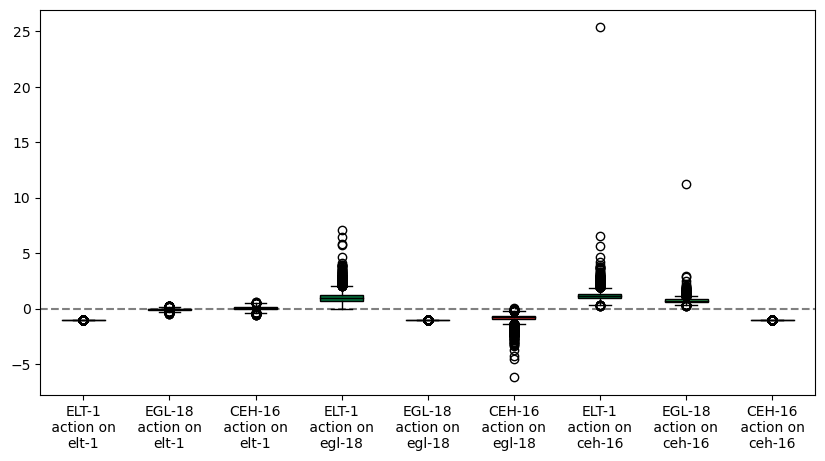



Response matrix or gene expression matrix for ['V5']


,ELT-1,EGL-18,CEH-16
elt-1,-1.11,0.09,-0.14
egl-18,-0.04,-2.00,1.16
ceh-16,-1.26,-1.33,-1.63



Network interaction map or connectivity matrix for ['V5']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.07,0.04
egl-18,0.98,-1.00,-0.83
ceh-16,1.14,0.73,-1.00



Min network interaction map or connectivity matrix for ['V5']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.46,-0.61
egl-18,-0.08,-1.00,-6.21
ceh-16,0.22,0.23,-1.00



Max network interaction map or connectivity matrix for ['V5']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.22,0.55
egl-18,7.07,-1.00,0.04
ceh-16,25.37,11.23,-1.00



Lower network interaction map or connectivity matrix for ['V5']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.23,-0.24
egl-18,0.35,-1.00,-1.32
ceh-16,0.66,0.49,-1.00



Upper network interaction map or connectivity matrix for ['V5']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.08,0.29
egl-18,1.81,-1.00,-0.46
ceh-16,1.74,1.03,-1.00



Invertible Rp = 10000 



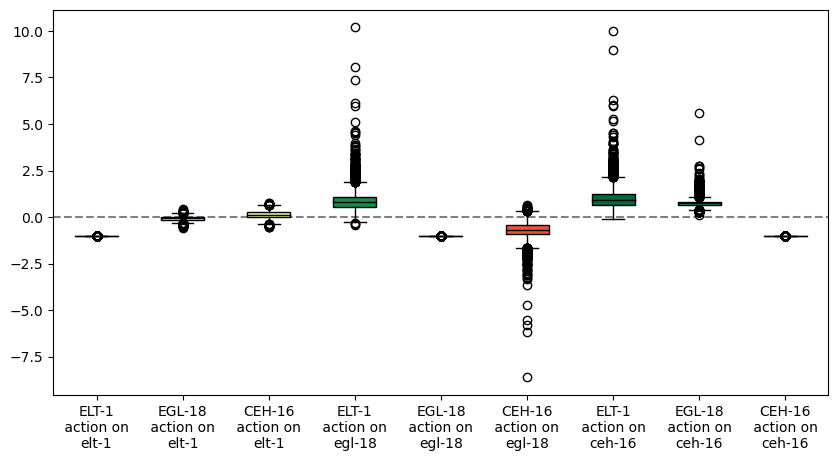



Response matrix or gene expression matrix for ['V6']


,ELT-1,EGL-18,CEH-16
elt-1,-1.16,-0.04,-0.26
egl-18,-0.14,-2.00,0.86
ceh-16,-1.22,-1.49,-1.70



Network interaction map or connectivity matrix for ['V6']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.07,0.12
egl-18,0.84,-1.00,-0.68
ceh-16,0.99,0.74,-1.00



Min network interaction map or connectivity matrix for ['V6']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.58,-0.54
egl-18,-0.41,-1.00,-8.62
ceh-16,-0.13,0.10,-1.00



Max network interaction map or connectivity matrix for ['V6']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.41,0.74
egl-18,10.19,-1.00,0.65
ceh-16,9.99,5.56,-1.00



Lower network interaction map or connectivity matrix for ['V6']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.25,-0.20
egl-18,0.19,-1.00,-1.24
ceh-16,0.36,0.49,-1.00



Upper network interaction map or connectivity matrix for ['V6']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.09,0.43
egl-18,1.61,-1.00,-0.04
ceh-16,1.80,1.02,-1.00



Invertible Rp = 10000 



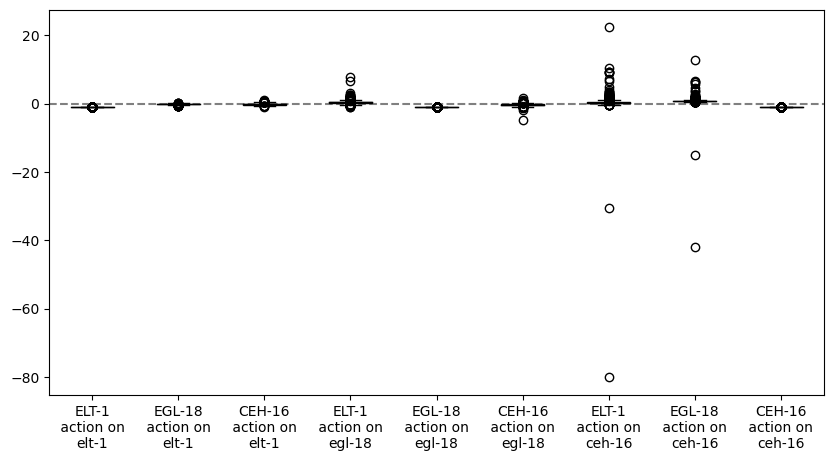



Response matrix or gene expression matrix for ['T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.03,0.40,0.16
egl-18,-0.25,-2.00,0.59
ceh-16,-0.53,-1.39,-1.70



Network interaction map or connectivity matrix for ['T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.11,-0.13
egl-18,0.41,-1.00,-0.31
ceh-16,0.36,0.77,-1.00



Min network interaction map or connectivity matrix for ['T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.70,-0.85
egl-18,-1.06,-1.00,-4.88
ceh-16,-80.07,-41.94,-1.00



Max network interaction map or connectivity matrix for ['T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.20,0.94
egl-18,7.93,-1.00,1.63
ceh-16,22.30,12.72,-1.00



Lower network interaction map or connectivity matrix for ['T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,-0.31,-0.46
egl-18,-0.01,-1.00,-0.67
ceh-16,-0.07,0.61,-1.00



Upper network interaction map or connectivity matrix for ['T']


,ELT-1,EGL-18,CEH-16
elt-1,-1.00,0.05,0.23
egl-18,0.88,-1.00,0.07
ceh-16,0.92,1.01,-1.00



Invertible Rp = 10000 



In [16]:
#FIND INTERACTION MAPS WITH 30 SAMPLES FOR SINGLE CELLS
group4 = Seam_cells
for k in group4:
    data = {}
    #prepare the data
    data[k] = {'elt-1':{}, 'egl-18':{}, 'ceh-16':{}}
    for i in Genes:
        for j in Genotypes:
            data[k][i][j] = np.array(pd_DATA[i][j][pd_DATA[i][j].Cell == k].mRNA, dtype='float64')
    #print(data)
    Rp_cells_p4, r_cells_p4, inv_count_p4, r_min_p4, r_max_p4, r_low_p4, r_up_p4 = MRA_average_discarding_non_inv_group_CI_fixed_perturbations(data, [k])

    visualize1 = pd.DataFrame(Rp_cells_p4, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
    print("\n\nResponse matrix or gene expression matrix for", [k])
    display(visualize1.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

    visualize2 = pd.DataFrame(r_cells_p4, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
    print("\nNetwork interaction map or connectivity matrix for", [k])
    display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
    visualize2 = pd.DataFrame(r_min_p4, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
    print("\nMin network interaction map or connectivity matrix for", [k])
    display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
    visualize2 = pd.DataFrame(r_max_p4, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
    print("\nMax network interaction map or connectivity matrix for", [k])
    display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
    visualize2 = pd.DataFrame(r_low_p4, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
    print("\nLower network interaction map or connectivity matrix for", [k])
    display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))
    visualize2 = pd.DataFrame(r_up_p4, index=pd.Index(mRNA), columns=pd.Index(Proteins)).round(2)
    print("\nUpper network interaction map or connectivity matrix for", [k])
    display(visualize2.style.background_gradient(cmap='RdYlGn', vmin=-1.0, vmax=1.0).format('{:.2f}'))

    print("\nInvertible Rp =", inv_count_p4, "\n")